In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
from pylab import rcParams
import re
import os
import time
from datetime import datetime

In [2]:
%matplotlib inline
rcParams['figure.figsize'] = 5, 4

In [3]:
df = pd.read_csv("readings.csv")
df.head()

,cpu_speed,volts,fan_speed,cpu_pct,load_avg,temp
0,1.500013,0.7200,3019.0,5.1,0.577148,46.6
1,2.400024,0.8806,3020.0,23.3,0.577148,46.6
2,2.400020,0.8806,3021.0,1.9,0.577148,47.2
3,2.400020,0.8806,3020.0,1.9,0.577148,47.2
4,2.400030,0.8806,3021.0,1.0,0.577148,46.6


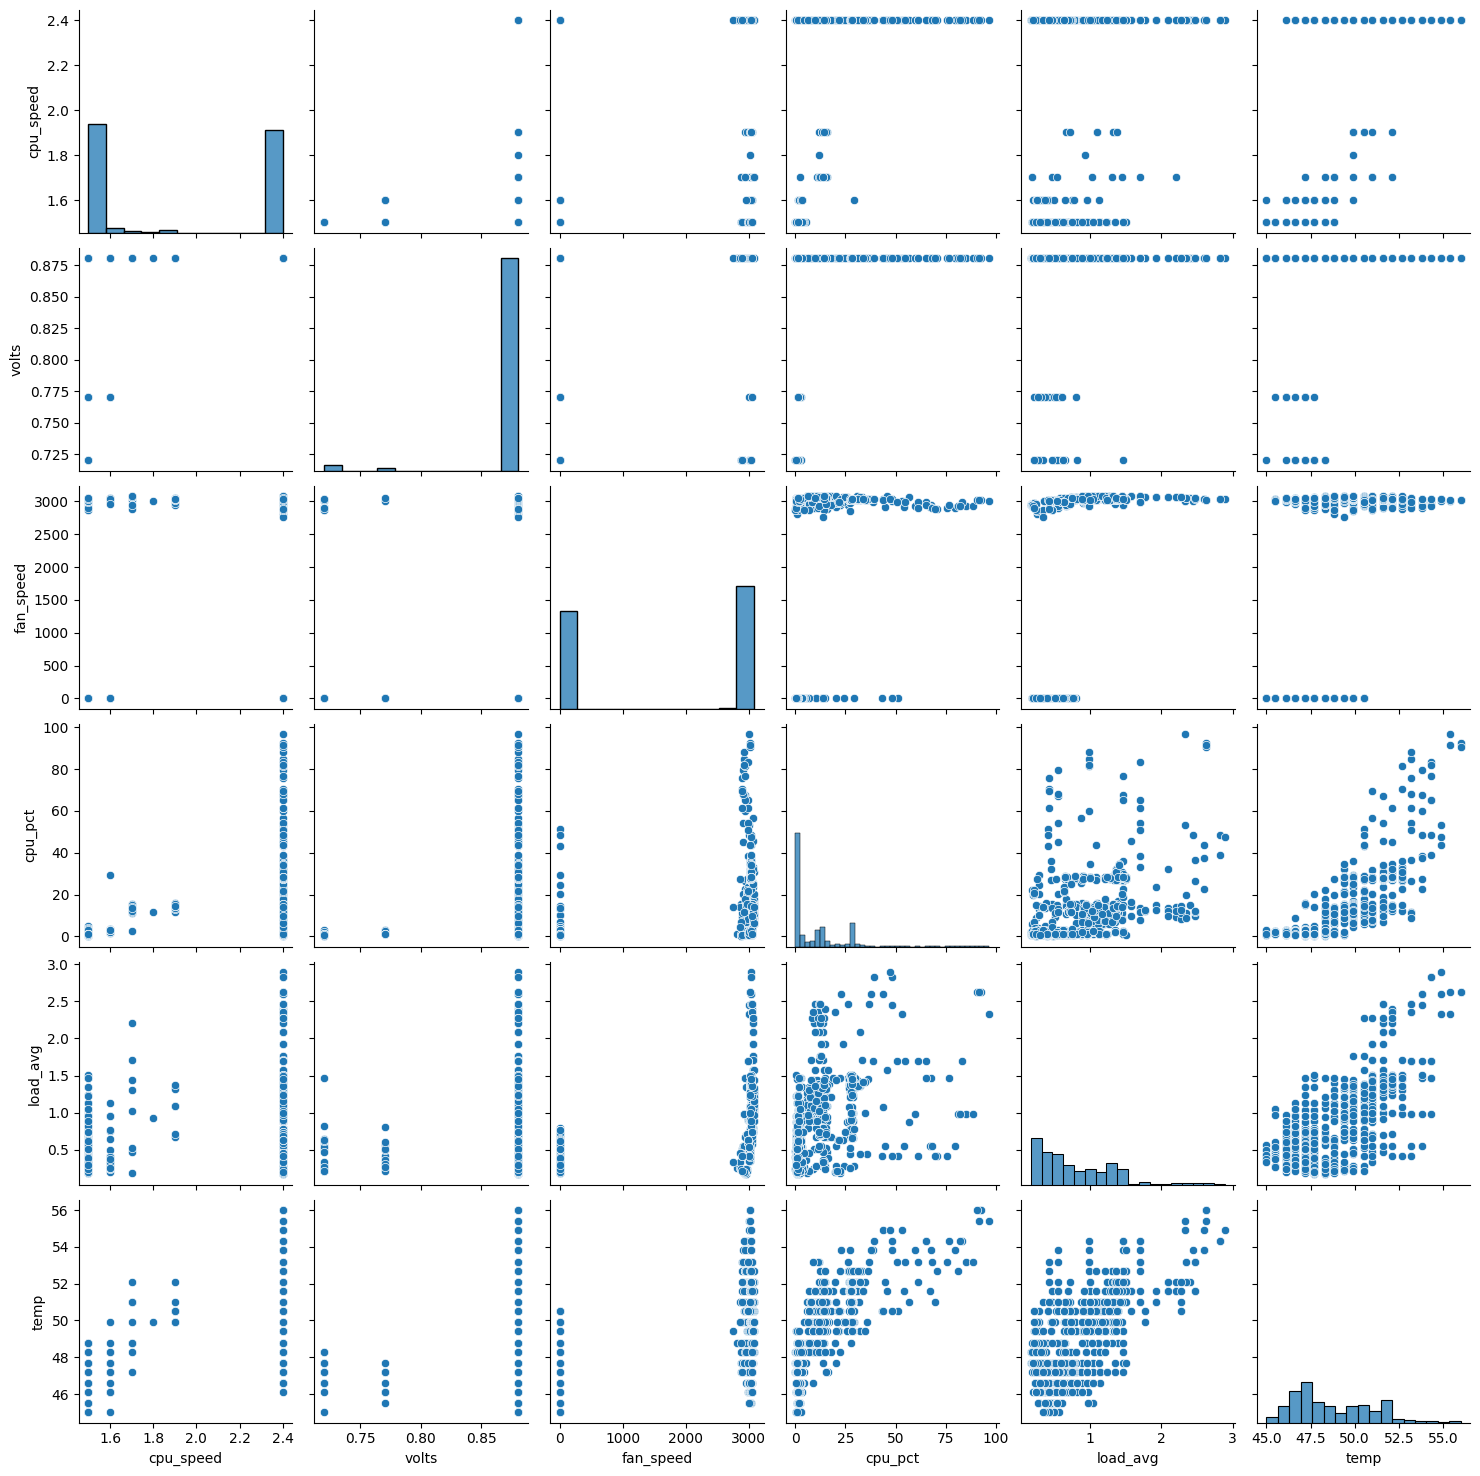

In [4]:
sns.pairplot(df.sample(1000))

In [5]:
display(df.corr())

# We can strengthen our correlation by applying a rolling average to certain columns.
df_adjusted = df.copy()
rolling_cols = ['cpu_speed', 'volts', 'fan_speed', 'cpu_pct']
df_adjusted[rolling_cols] = df_adjusted[rolling_cols].rolling(window=5).mean()
display(df_adjusted.corr())

,cpu_speed,volts,fan_speed,cpu_pct,load_avg,temp
cpu_speed,1.000000,0.177681,0.702697,0.606381,0.587484,0.801637
volts,0.177681,1.000000,0.045159,0.112846,0.131240,0.133572
fan_speed,0.702697,0.045159,1.000000,0.480698,0.650322,0.648469
cpu_pct,0.606381,0.112846,0.480698,1.000000,0.599708,0.809144
load_avg,0.587484,0.131240,0.650322,0.599708,1.000000,0.766714
temp,0.801637,0.133572,0.648469,0.809144,0.766714,1.000000


,cpu_speed,volts,fan_speed,cpu_pct,load_avg,temp
cpu_speed,1.000000,0.266795,0.727922,0.650388,0.614881,0.824529
volts,0.266795,1.000000,0.073997,0.178357,0.201503,0.205284
fan_speed,0.727922,0.073997,1.000000,0.506010,0.655393,0.645568
cpu_pct,0.650388,0.178357,0.506010,1.000000,0.644502,0.836964
load_avg,0.614881,0.201503,0.655393,0.644502,1.000000,0.766714
temp,0.824529,0.205284,0.645568,0.836964,0.766714,1.000000


In [6]:
from sklearn.preprocessing import scale
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Grab the adjusted data, but drop any rows with missing data.
# The rows with missing data were created by the rolling average.
df_data = df_adjusted.dropna(how="any")

# Try it first with one column, then with more than one. Comment out
# the one you don't want to use and uncomment the one you do.
# feature_cols = ["load_avg"]
feature_cols = ["volts", "cpu_pct", "load_avg", "cpu_speed", "fan_speed"]

# Separate the feature data from the target data we want to predict.
data = df_data[feature_cols].values
target = df_data.temp.values

# X,y = scale(data), target
X,y = data, target

assert df_data[df_data.isna().any(axis=1)].shape[0] == 0, "Found NaN values in data"
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=200, shuffle=True)
display(f"Train length: {len(X_train)}, Test length: {len(X_test)}")

'Train length: 2296, Test length: 200'

'Mean squared error: 0.68'

'Coefficient of determination: 0.88'

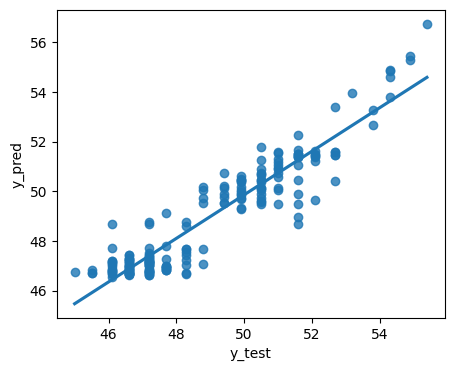

In [7]:
linreg = LinearRegression()
linreg.fit(X_train,y_train)
y_pred = linreg.predict(X_test)

sns.regplot(x=y_test, y=y_pred, ci=None)
plt.xlabel('y_test')
plt.ylabel('y_pred')

display(f"Mean squared error: {mean_squared_error(y_test, y_pred):.2f}")
display(f"Coefficient of determination: {r2_score(y_test, y_pred):.2f}")


In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

df_data = df_adjusted.dropna(how="any").copy()

df_data["fan_state"] = (df_data.fan_speed > 0).replace({True: "on", False: "off"})

feature_cols = ["volts", "cpu_pct", "load_avg", "cpu_speed", "temp"] # NOT fan speed!
data = df_data[feature_cols].values
target = df_data.fan_state.values
X,y = scale(data), target
assert df_data[df_data.isna().any(axis=1)].shape[0] == 0, "Found NaN values in data"
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=200, shuffle=True)
display(f"Train length: {len(X_train)}, Test length: {len(X_test)}")

'Train length: 2296, Test length: 200'

In [9]:
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print(metrics.classification_report(y_test, y_pred))
display(metrics.confusion_matrix(y_test, y_pred))



              precision    recall  f1-score   support

         off       0.84      0.97      0.90        78
          on       0.98      0.88      0.93       122

    accuracy                           0.92       200
   macro avg       0.91      0.93      0.91       200
weighted avg       0.92      0.92      0.92       200



array([[ 76,   2],
       [ 15, 107]])